In [1]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt
import os
import time


import mmap
import struct
import subprocess

In [2]:
def run_command(command):
    """Ejecuta un comando en la terminal y muestra la salida en tiempo real."""
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    for line in process.stdout:
        print(line, end="")  # Imprime la salida en tiempo real

    process.wait()  # Esperar a que termine el proceso
    if process.returncode != 0:
        print(f"\nError en el comando: {command}")
        print(process.stderr.read())

In [3]:
run_command("xmutil unloadapp")
run_command("xmutil loadapp ictp_dma")

remove from slot 0 returns: 0 (Ok)
ictp_dma: loaded to slot 0


In [4]:
# Cargar la librería
lib = ctypes.CDLL("./dma_library/libuio_dma.so")

In [5]:
# Prototipos
lib.dma_open_mem.restype = ctypes.c_void_p
lib.dma_open_mem.argtypes = [ctypes.c_long, ctypes.c_size_t, ctypes.c_long, ctypes.c_size_t]

lib.dma_start_and_wait.restype = ctypes.c_int
lib.dma_start_and_wait.argtypes = [ctypes.c_void_p, ctypes.c_uint32, ctypes.c_int]

lib.dma_read_reg.restype = ctypes.c_uint32
lib.dma_read_reg.argtypes = [ctypes.c_void_p, ctypes.c_uint32]

lib.dma_get_buffer_ptr.restype = ctypes.c_size_t
lib.dma_get_buffer_ptr.argtypes = [ctypes.c_void_p]

lib.dma_close.restype = None
lib.dma_close.argtypes = [ctypes.c_void_p]

In [6]:
# Parámetros idénticos a tu script Python
DMA_REGS_PHY = 0x80010000
DMA_REGS_SIZE = 65536
DST_PHYS = 0x0c000000
DST_MAP_SIZE = 8192 * 4

Opening handle via /dev/mem (C lib)...
Initial STATUS (from C lib) = 0x00000001
Starting DMA (C lib)...
DMA finished OK (C lib)
Tiempo total DMA (Python mmap): 3.827 ms
Tiempo total DMA (Python mmap): 0.309 ms
First 16 words: [51700 52354 52995 53624 30751 29946 29142 28341 27542 26747 25955 25168
 24385 23607 22834 22068]


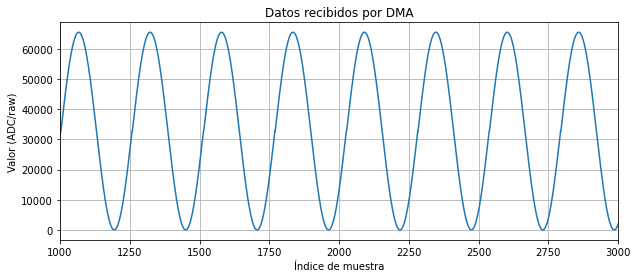

In [7]:
###################################################
t0 = time.perf_counter()

print("Opening handle via /dev/mem (C lib)...")
h = lib.dma_open_mem(DMA_REGS_PHY, DMA_REGS_SIZE, DST_PHYS, DST_MAP_SIZE)
if not h:
    raise RuntimeError("dma_open_mem failed")

# Leer status inicial (debug)
st = lib.dma_read_reg(h, 0x34)
print(f"Initial STATUS (from C lib) = 0x{st:08X}")

print("Starting DMA (C lib)...")
ret = lib.dma_start_and_wait(h, ctypes.c_uint32(DST_MAP_SIZE), 5000)
if ret == 0:
    print("DMA finished OK (C lib)")
elif ret == 1:
    print("DMA TIMEOUT (C lib)")
else:
    print("DMA ERROR (C lib)")
    
t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")


# Si terminó, leer buffer via pointer -> numpy
if ret == 0:
    ###################################################
    t0 = time.perf_counter()
    
    ptr = lib.dma_get_buffer_ptr(h)
    # create numpy array view: shape = DST_MAP_SIZE/4
    length_words = DST_MAP_SIZE // 4
    buffer_type = ctypes.c_uint32 * length_words
    buf = buffer_type.from_address(ptr)
    np_arr = np.ctypeslib.as_array(buf)
    
    t1 = time.perf_counter()
    ###################################################
    print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")
    
    print("First 16 words:", np_arr[:16])
    
    data = np.array(np_arr, dtype=np.uint16)

    # Crear eje x (muestras)
    x = np.arange(len(data))

    # Graficar
    plt.figure(figsize=(10,4))
    plt.plot(x, data)
    plt.title("Datos recibidos por DMA")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Valor (ADC/raw)")
    plt.grid(True)
    # plt.show()
    plt.xlim([1000,3000])

lib.dma_close(h)

Initial STATUS (from C lib) = 0x00005011
Starting DMA (C lib)...
DMA finished OK (C lib)
Tiempo total DMA (Python mmap): 3.498 ms
Tiempo total DMA (Python mmap): 0.152 ms


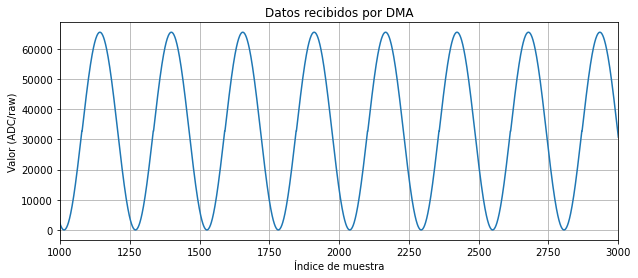

In [8]:
###################################################
t0 = time.perf_counter()

h = lib.dma_open_mem(DMA_REGS_PHY, DMA_REGS_SIZE, DST_PHYS, DST_MAP_SIZE)
if not h:
    raise RuntimeError("dma_open_mem failed")

# Leer status inicial (debug)
st = lib.dma_read_reg(h, 0x34)
print(f"Initial STATUS (from C lib) = 0x{st:08X}")

print("Starting DMA (C lib)...")
ret = lib.dma_start_and_wait(h, ctypes.c_uint32(DST_MAP_SIZE), 5000)
if ret == 0:
    print("DMA finished OK (C lib)")
elif ret == 1:
    print("DMA TIMEOUT (C lib)")
else:
    print("DMA ERROR (C lib)")
    
t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")


# Si terminó, leer buffer via pointer -> numpy
if ret == 0:
    ###################################################
    t0 = time.perf_counter()
    
    ptr = lib.dma_get_buffer_ptr(h)
    # create numpy array view: shape = DST_MAP_SIZE/4
    length_words = DST_MAP_SIZE // 4
    buffer_type = ctypes.c_uint32 * length_words
    buf = buffer_type.from_address(ptr)
    np_arr = np.ctypeslib.as_array(buf)
    
    t1 = time.perf_counter()
    ###################################################
    print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")
    
    data = np.array(np_arr, dtype=np.uint16)

    # Crear eje x (muestras)
    x = np.arange(len(data))

    # Graficar
    plt.figure(figsize=(10,4))
    plt.plot(x, data)
    plt.title("Datos recibidos por DMA")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Valor (ADC/raw)")
    plt.grid(True)
    # plt.show()
    plt.xlim([1000,3000])

lib.dma_close(h)

Run 01: DMA = 0.534 ms, Read = 0.092 ms
Run 02: DMA = 0.668 ms, Read = 0.052 ms
Run 03: DMA = 0.528 ms, Read = 0.035 ms
Run 04: DMA = 0.811 ms, Read = 0.040 ms
Run 05: DMA = 0.529 ms, Read = 0.035 ms
Run 06: DMA = 0.523 ms, Read = 0.034 ms
Run 07: DMA = 0.521 ms, Read = 0.034 ms
Run 08: DMA = 0.541 ms, Read = 0.036 ms
Run 09: DMA = 0.518 ms, Read = 0.035 ms
Run 10: DMA = 0.634 ms, Read = 0.037 ms
Run 11: DMA = 0.552 ms, Read = 0.038 ms
Run 12: DMA = 0.524 ms, Read = 0.035 ms
Run 13: DMA = 0.549 ms, Read = 0.035 ms
Run 14: DMA = 0.523 ms, Read = 0.035 ms
Run 15: DMA = 0.522 ms, Read = 0.038 ms
Run 16: DMA = 0.546 ms, Read = 0.038 ms
Run 17: DMA = 0.525 ms, Read = 0.036 ms
Run 18: DMA = 0.589 ms, Read = 0.037 ms
Run 19: DMA = 0.526 ms, Read = 0.035 ms
Run 20: DMA = 0.519 ms, Read = 0.034 ms

=== Benchmark summary (20 runs, C lib) ===
DMA avg:   0.559 ms (± 0.070)
Read avg:  0.040 ms (± 0.013)


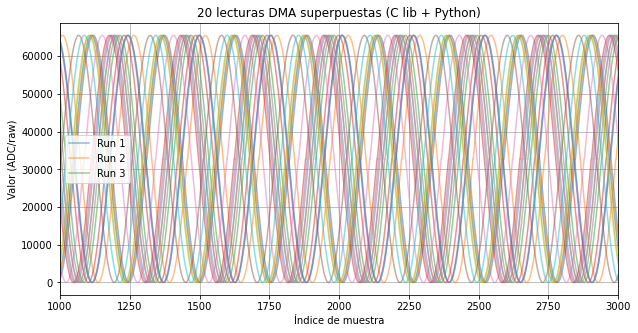

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
import ctypes

num_runs = 20
dma_times = []
read_times = []
all_data = []

# Abrir el handle una sola vez
h = lib.dma_open_mem(DMA_REGS_PHY, DMA_REGS_SIZE, DST_PHYS, DST_MAP_SIZE)
if not h:
    raise RuntimeError("dma_open_mem failed")

for i in range(num_runs):
    # -------------------------
    # Medir tiempo DMA
    # -------------------------
    t0 = time.perf_counter()

    ret = lib.dma_start_and_wait(h, ctypes.c_uint32(DST_MAP_SIZE), 5000)

    t1 = time.perf_counter()
    dma_times.append((t1 - t0) * 1e3)

    if ret == 0:
        # -------------------------
        # Medir tiempo de lectura
        # -------------------------
        t0 = time.perf_counter()

        ptr = lib.dma_get_buffer_ptr(h)
        length_words = DST_MAP_SIZE // 4
        buffer_type = ctypes.c_uint32 * length_words
        buf = buffer_type.from_address(ptr)
        np_arr = np.ctypeslib.as_array(buf)

        t1 = time.perf_counter()
        read_times.append((t1 - t0) * 1e3)

        # Guardar copia en uint16 para graficar
        data = np.array(np_arr, dtype=np.uint16)
        all_data.append(data)

        print(f"Run {i+1:02d}: DMA = {dma_times[-1]:.3f} ms, Read = {read_times[-1]:.3f} ms")

    elif ret == 1:
        print(f"Run {i+1:02d}: DMA TIMEOUT")
    else:
        print(f"Run {i+1:02d}: DMA ERROR")

# -------------------------
# Estadísticas
# -------------------------
print("\n=== Benchmark summary (20 runs, C lib) ===")
print(f"DMA avg:   {np.mean(dma_times):.3f} ms (± {np.std(dma_times):.3f})")
print(f"Read avg:  {np.mean(read_times):.3f} ms (± {np.std(read_times):.3f})")

# -------------------------
# Graficar todas las curvas
# -------------------------
if all_data:
    plt.figure(figsize=(10,5))
    x = np.arange(len(all_data[0]))

    for i, d in enumerate(all_data):
        plt.plot(x, d, alpha=0.5, label=f"Run {i+1}" if i < 3 else None)

    plt.title("20 lecturas DMA superpuestas (C lib + Python)")
    plt.xlabel("Índice de muestra")
    plt.ylabel("Valor (ADC/raw)")
    plt.grid(True)
    plt.xlim([1000, 3000])
    plt.legend()
    plt.show()

lib.dma_close(h)